<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_09_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning: An Introduction

In this tutorial, we will enter the world of Deep Reinforcement Learning (DRL). In particular, we will first familiarize ourselves with some basic concepts of Reinforcement Learning (RL), then we will implement a classical tabular Q-learning method for the classic [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) puzzle and finally, implement a Deep Q-learning approach for the [CartPole](https://gym.openai.com/envs/CartPole-v1/) problem.


> 



![alt text](https://media2.giphy.com/media/46ib09ZL1SdWuREnj3/giphy.gif?cid=3640f6095c6e92762f3446634d90bc65) ![alt text](https://media0.giphy.com/media/d9QiBcfzg64Io/200w.webp?cid=3640f6095c6e93e92f30655873731752)![alt text](https://i.gifer.com/GpAY.gif)

The gifs above, show the results obtained by [deepmind](https://arxiv.org/pdf/1312.5602v1.pdf) in one of their latest papers. They successfully trained an RL agent using deep Q-learning to play classical Atari arcade games. Let's see now how they did it.








# Q-Learning 

This family of RL methods try to learn an approximator of the action-value functions $Q(s,a)$  based on the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation), such that the update using a classical [gradient descent ](https://en.wikipedia.org/wiki/Gradient_descent) formulation is given by:
$$Q\left(s,a\right)=Q\left(s,a\right)+ \alpha \left(r+\gamma \max _{a} Q\left(s_{t+1},a\right)-Q\left(s,a\right)\right).$$
Where $\alpha$ is the step size. 
 Q-Learning updates the estimated reward at each time step and  uses the old estimate $ \max _{a}Q\left(s_{t+1},a\right)$ to update the new ones. In a more algorithmic way, the Q-Learning process is the following:


1.   Initialize Q-values at random $Q\left(s,a\right)$.
2. Forever or until learning is stopped do:
> 1.  Observe state $s$.
> 2.   Take action $a$ according to your policy, e.g., $\epsilon-greedy$.
> 3.   Observe reward $r$ and new state $s_{t+1}$.
> 4. Based on your actual estimates, compute $\max _{a}Q\left(s_{t+1},a\right)$.
> 5. Update your current estimate for  $Q\left(s,a\right)$:
$$Q\left(s,a\right)=Q\left(s,a\right)+ \alpha \left(r+\gamma \max _{a} Q\left(s_{t+1},a\right)-Q\left(s,a\right)\right).$$

Okay, now that we are familiar with Q-Learning lets jump to a real implementation of it.







## Tabular Q-Learning with Frozen Lake
In this section we will teach an agent how to play  the [Frozen lake](https://gym.openai.com/envs/FrozenLake-v0/) game using a classical tabular Q-learning. Brace yourselves, winter is coming! 

![alt text](https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/1ee37cfc3130057f828f19b3cee6066d41c1eeb4/Q%20learning/FrozenLake/frozenlake.png)

Winter has arrived and you and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so you must navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.
The goal of this game is to go from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery (!!), so you won't always move in the direction you intend (stochastic environment), i.e., there is a probability $p$ that you move in the direcction selected and a probability $(1-p)$ that given the slippery ice, you move to a random position near positon. 

The lake is represented by a 4x4 grid and the location where the frisbee has landed (G) as well as the holes (H) is always the same for every new game. The game is restarted every time you have successfully recovered the frisbee or you have fallen into the cold waters. A reward of +1 is given every time you recover the frisbee and 0 other way.


**Step 0: Import the needed libraries:**

We will be using 3 libraries:

* Numpy for our Qtable.
* OpenAI Gym for our FrozenLake Environment
* Random to generate random numbers



In [ ]:

from IPython.display import HTML
import numpy as np
import gym
import random

**Environment creation:**

OpenAi is  a library composed of many environments that we can use to train our agents, in our case we choose to use the Frozen Lake.

In [ ]:
env = gym.make("FrozenLake-v0")

**Q-table**

 Now, we'll create our Q-table. The goal of the Q-table is to store the estimates $Q\left(s,a\right)$ and retrieve them when necessary. In this game the states are represented by each of the 16 grid positions being 0 the starting position and 16 the goal position and the actions are 4: left, right, up and down. Our Q-table will have then $16 \times 4$ positions, where the value of the first column of the first row represents the expected return of being in position 0 and taking left.
 
The number of rows (states) and columns (actions) the table will have can also be obtained using the values action_size and the state_size from the OpenAI Gym library: *env.action_space.n* and* env.observation_space.n*.
 
We initialize the table to 0.

In [29]:
action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


**Hyperparameters**

Following, we specify the hyperparameters:


In [ ]:
total_episodes = 25000        # Total episodes
learning_rate = 0.8           # Learning rate (alpha in the previous formulation)
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

At first, we don't know how to interact with the environment (Q-table values set to 0), so we start exploring it by taking a random action with probability $\epsilon=1$, capturing the rewards obtained and updating the Q-values of the table accordingly. As time passes by, we start knowing more and more the environment, so we reduce (decay_rate) the probability of taking a random action and we start exploiting our knowledge, we choose the action that leads us to the highest reward, i.e., the one with the highest Q-value.

In [ ]:
# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005             # Exponential decay rate for exploration prob

**Q-Learning**

Now we implement the Q-Learning algorithm: 
> 1.  Observe state $s$.
> 2.   Choose a random value $v$ between 0 and 1.
> 3. If $v<\epsilon$, we choose a random action, otherwise we select the action with maximum $Q(s,a)$.
> 3.   Observe reward $r$ and new state $s_{t+1}$.
> 4. Based on your previous estimates, compute $\max _{a}Q\left(s_{t+1},a\right)$.
> 5. Update your current estimates for  $Q\left(s,a\right)$:
$$Q\left(s,a\right)=Q\left(s,a\right)+ \alpha \left(r+\gamma \max _{a} Q\left(s_{t+1},a\right)-Q\left(s,a\right)\right).$$


In [32]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 0.48228
[[8.95202924e-02 4.65700361e-02 3.11526745e-02 2.31793510e-02]
 [1.79576545e-03 8.52235298e-03 3.11178843e-03 4.70788205e-02]
 [7.52145430e-03 3.77888986e-03 5.08789075e-03 1.27684143e-02]
 [5.54158586e-03 3.47388644e-03 5.83752772e-04 9.41714105e-03]
 [2.64890655e-01 3.51583419e-03 2.67191272e-03 2.64145741e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.81363021e-07 9.36653948e-08 5.78388741e-01 5.57842311e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.75962476e-02 7.31171180e-02 1.38677588e-02 5.58551665e-01]
 [3.00688287e-03 5.05330804e-01 2.38334528e-02 5.25582338e-02]
 [6.58223827e-03 9.05621775e-02 1.45846037e-03 5.86858537e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.45135112e-02 7.10784869e-03 8.40126934e-01 1.50147889e-01]
 [1.76449637e-01 9.96131251e-01 2.23383343e-01 1.97243696e-01]
 [0.00000000e+00 0.00000000e+0

**Use our Q-table to play FrozenLake!**

After 10 000 episodes, our Q-table can be used as a "cheatsheet" to play FrozenLake"!
  
By running this cell, you can see our agent playing FrozenLake:

In [ ]:
env.reset()

state = env.reset()
step = 0
done = False
print("****************************************************")
env.render()
for step in range(max_steps):

    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(qtable[state,:])

    new_state, reward, done, info = env.step(action)

    env.render()

    # We print the current step.
    print("Number of steps", step)
    if done:
      break
    state = new_state
env.close()

Let’s see how many times our agent finds the frisbee 🎉🎉🎉

To this end we will print the last step of the game.

In [33]:
games=5
step = 0
done = False
print("****************************************************")
for game in range(games):
  env.reset()
  state = env.reset()
  for step in range(max_steps):

      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(qtable[state,:])

      new_state, reward, done, info = env.step(action)

      if done:
        # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
        env.render()

        # We print the number of step it took.
        print("Number of steps", step)
        done= False
        break
      state = new_state
  env.close()

****************************************************
  (Down)
SFFF
FHFH
FFFH
HFFG
Number of steps 16
  (Down)
SFFF
FHFH
FFFH
HFFG
Number of steps 47
  (Down)
SFFF
FHFH
FFFH
HFFG
Number of steps 78
  (Down)
SFFF
FHFH
FFFH
HFFG
Number of steps 17


## CartPole

That wasn't so hard! How about trying to balance a pole so it does not fall? In this section we will address the [CartPole](https://gym.openai.com/envs/CartPole-v1/) problem, let's get to it!

![texto alternativo](https://keon.github.io/images/deep-q-learning/animation.gif)

As before we will use Q-learning to train our agent, so let's start by constructing our Q-table. We first need to find out the number of columns and rows of it. By checking the environment specifications of [OpenAi](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py), we see that the actions are left and right, so we need two columns for the actions. On the other hand, the state information is given by:

        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
      
The cart position goes from -4.8 to 4.8 with a resolution of 0.01, that means $\frac{4.8 \times 2}{0.01}=960$ possible carts positions, while the cart velocity goes from $-\infty$ to $\infty$!!. How we are going to construct a table with $\infty$ rows?!?!
 
Do not panic! That is when deep learning steps up and takes over the stage. As you have already seen the use of deep Neural Networks as general function approximators have been proven to work very well in wide range of areas, reinforcement learning is not an exception. In this case we will use the NNs as function approximation between the mapping of states to actions, so for every input state, we want the NNs to output an approximation of the $Q\left(s,a\right)$.

![alt text](https://proxy.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1318%2F1*Gh5PS4R_A5drl5ebd_gNrg%402x.png&f=1)

In this particular scenario, the input layer will have the same number of inputs as environment parameters, 4, and the output layer will have the same number of outputs as actions, in this case 2. 

**Reward:** A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical.



**Step 0: Import the needed libraries**

We start by importing the needed libraries:
We will be using 3 libraries:
* Keras: for our DNNs.
* OpenAI Gym: for our CartPole Environment
* Random: to generate random numbers.
* Collections: Collection will be use to create a memory buffer to store the tuples $\left(S_t, A_t, R_t,S_{t+1}\right)$ of transactions. 

The idea behind the use of a memory buffer is that most optimization algorithms, including gradient descent, assume that the samples which the gradient is obtained are independent and identically distributed. Clearly in the defined environment is not the case, however, by sampling uniformly the memory buffer with a high number of samples the correlation between contiguous samples is broken and less likely to be correlated samples are used to update the networks weights, leading to a stable optimization of the action-parameter selection.


In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os

**The Agent**

Let's start by coding a general DQ-Learning agent. The state and action size are passed as parameters and we configure a replay buffer to have capacity to store 2000 experienced transitions.

In [ ]:
 class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

Now we address the DDNs; we are going to use two fully connected layers of 24 neurons each and as an optimizer we select  adam optimizer.

In [ ]:
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

Now define the method to store the transictions into the memory buffer.
The parameter done is a boolean returned true when the pole has fallen. 

In [ ]:
    def remember(self, state, action, reward, next_state, done):
          self.memory.append((state, action, reward, next_state, done))

Again, we implement and $\epsilon-greedy$ policy.

In [ ]:
     def act(self, state):
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
            act_values = self.model.predict(state)
            return np.argmax(act_values[0]) # returns action

Then comes the implementation of the Q-Learning method:



1.   We obtain the samples to train the DNN from the replay buffer.
2.  We compute $target=r+\gamma \max _{a} Q\left(s_{t+1},a\right)$, by doing a forward pass using next_state value.
3. We do a forward pass through the network to obtain the $Q\left(s,a\right)$ for all the possible actions.
4. In order to just update the paramater of the action taken, we copy target to the value of the $Q\left(s,a\right)$ of the actual $a$ taken.
5. We update the parameters of the network using MSE as loss function.




In [ ]:
def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    ### This code below generates batches of states, actions, rewards
    ### next states out of the sampled minibatch
    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))
  
    target = (reward_b + self.gamma *
                      np.amax(self.model.predict(next_state_b), 1))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b)
    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.train_on_batch(state_b, target_f)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay


Now we define the operations to load and save the models.

In [ ]:
def load(self, name):
  self.model.load_weights(name)
def save(self, name):
  self.model.save_weights(name)

Colab does not recognize all the previous code parts defined under the same class, to this end we run everything this time altogether. 

In [ ]:
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95    # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()

  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):# We implement the epsilon-greedy policy
    if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0]) # returns action
  
  def exploit(self, state): # When we test the agent we dont want it to explore anymore, but to exploit what it has learnt
    act_values = self.model.predict(state)
    return np.argmax(act_values[0]) 

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    
    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))
    target = (reward_b + self.gamma *
                      np.amax(self.model.predict(next_state_b), 1))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b)
    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.train_on_batch(state_b, target_f)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

**Main**

Following we implement the training of the agent. (Warning: it might take a while)

In [ ]:
EPISODES = 500
env = gym.make ('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

Let's now visualize how the agent is performing:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
from gym.wrappers import Monitor
import glob
import io
import base64

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
env = wrap_env(gym.make('CartPole-v1'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
done = False
state = env.reset()
state = np.reshape(state, [1, state_size])
for time in range(500):
    screen = env.render()
    action = agent.exploit(state)
    state, reward, done, _ = env.step(action)
    state = np.reshape(state, [1, state_size])

    if done:
        print("episode: {}/{}, score: {}, e: {:.2}"
              .format(e, EPISODES, time, agent.epsilon))
        break
env.close()
show_video()
env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode: 499/500, score: 157, e: 0.01


array([-0.00747298,  0.02776177,  0.02039639, -0.00138892])

You can have a look of the tutorials and code prepared by [OpenAI](https://spinningup.openai.com/en/latest/user/introduction.html) for further details on RL.

# Coursework

## Task 1: On-policy vs. Off-policy
Use the code given below to run the training loop, where the agent is trained for 500 episodes. The agent we give follows the Q-learning approach, which is an off-policy approach. You will now change the approach to SARSA, which is an on-policy approach. Also, for both Q-learning and SARSA test two different policies: $\epsilon$-greedy and Softmax. $\epsilon$-greedy is already defined in the tutorial and implemented in the agent. Softmax policy refers to sampling the next action following the probability distribution given by $Softmax(Q(s, a))$. We provide you the NumPy softmax function to normalize the Q-Values into a probability function to use before sampling. Similarly to RNN, in the softmax function, there is a temperature value involve, we set a value that works, but you can change it if it does improve for you. Report the new value if you decide to do so.

You will need to modify `act` and `replay` from the `DQNAgent` to implement the different approaches we ask for. Results may differ from run to run due to different initialization states. 

**Report**
* Plot the average reward for the last 100 episodes vs. number of training episodes for the four agents trained: Q-learning and SARSA with both $\epsilon$-greedy policy and Softmax policy.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import softmax
from keras.optimizers import Adam
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(777) # for reproducibility

def softmax(x, temperature=0.025): 
    """Compute softmax values for each sets of scores in x."""
    x = (x - np.expand_dims(np.max(x, 1), 1))
    x = x/temperature    
    e_x = np.exp(x)
    return e_x / (np.expand_dims(e_x.sum(1), -1) + 1e-5)

import pickle
def save_status(data, dest):
    outfile = open(dest, 'wb') 
    pickle.dump(data, outfile)                       
    outfile.close()
def load_status(f): 
    with open(f, 'rb') as infile:     
        status = pickle.load(infile) 
    return status

Using TensorFlow backend.


In [2]:
class DQNAgent:
  def __init__(self, state_size, action_size, policy):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95    # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()
    self.policy = policy

    
  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):# We implement the epsilon-greedy policy
    if self.policy == "epsilon-greedy":
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0]) # returns action
    
    elif self.policy == "softmax":
        act_values = self.model.predict(state)
        act_cdf = np.cumsum(softmax(act_values))
        rseed = np.random.random_sample()
        check_ls = [int(a < rseed) for a in act_cdf]
        chosen = np.sum(check_ls)
        if chosen == self.action_size:
            return chosen-1
        return chosen
        
    else:
        raise ValueError
    
  def exploit(self, state): # When we test the agent we dont want it to explore anymore, but to exploit what it has learnt
    act_values = self.model.predict(state)
    return np.argmax(act_values[0]) 

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    
    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

    ### Q-learning
    target = (reward_b + self.gamma * np.amax(self.model.predict(next_state_b), 1))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.train_on_batch(state_b, target_f)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [3]:
class SARSAAgent:
  def __init__(self, state_size, action_size, policy):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95    # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()
    self.policy = policy

    
  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, next_action, done):
    self.memory.append((state, action, reward, next_state, next_action, done))

  def act(self, state):# We implement the epsilon-greedy policy
    if self.policy == "epsilon-greedy":
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0]) # returns action
    
    elif self.policy == "softmax":
        act_values = self.model.predict(state)
        act_cdf = np.cumsum(softmax(act_values))
        rseed = np.random.random_sample()
        check_ls = [int(a < rseed) for a in act_cdf]
        chosen = np.sum(check_ls)
        if chosen == self.action_size:
            return chosen-1
        return chosen
        
    else:
        raise ValueError
    
  def exploit(self, state): # When we test the agent we dont want it to explore anymore, but to exploit what it has learnt
    act_values = self.model.predict(state)
    return np.argmax(act_values[0]) 

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    
    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    next_action_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[5], minibatch))))

    ### SARSA
#     ## DEBUG
#     print(f"prediction: {self.model.predict(next_state_b).shape}")
#     print(f"next_action_b: {next_action_b.shape}")
#     print(f"type next_action_b[0] {type(next_action_b[0])}")
#     ##
    q_vals = self.model.predict(next_state_b)
    target = (reward_b + self.gamma * np.array([q_vals[i][next_action_b[i]] for i in range(batch_size)]))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.train_on_batch(state_b, target_f)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [4]:
EPISODES = 500
# EPISODES = 10 # DEBUG
VERBOSE = False

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32

rewards_plot = []

agents = [DQNAgent(state_size, action_size, policy="epsilon-greedy"),
          DQNAgent(state_size, action_size, policy="softmax"),
          SARSAAgent(state_size, action_size, policy="epsilon-greedy"),
          SARSAAgent(state_size, action_size, policy="softmax")]

names = ["Q-learning (epsilon-greedy)", 
         "Q-learning (softmax)", 
         "SARSA (epsilon-greedy)", 
         "SARSA (softmax)"]

for agent in agents:
    rewards = []
    episode_reward_list = deque(maxlen=100)
    for e in tqdm(range(EPISODES)):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      total_reward = 0
      for time in range(1000):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        if type(agent) == DQNAgent:
            agent.remember(state, action, reward, next_state, done)
        else:
            next_action = agent.act(next_state)
            agent.remember(state, action, reward, next_state, next_action, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
      episode_reward_list.append(total_reward)
      episode_reward_avg = np.array(episode_reward_list).mean()
      rewards.append(episode_reward_avg)
      if not e%25 and VERBOSE:
          print("episode: {}/{}, score: {}, e: {:.2}, last 100 episodes rew: {:.2f}"
                  .format(e+1, EPISODES, total_reward, agent.epsilon, episode_reward_avg))      
    if VERBOSE:
        print("episode: {}/{}, score: {}, e: {:.2}, last 100 episodes rew: {:.2f}"
                  .format(e+1, EPISODES, total_reward, agent.epsilon, episode_reward_avg))
        
    rewards_plot.append(rewards)

results = {"names":names,"rewards_plot":rewards_plot}

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [07:42<00:00,  1.08it/s]


In [5]:
picklefile = "checkpoints_09/results4"

save_status(results, picklefile)

results = load_status(picklefile)

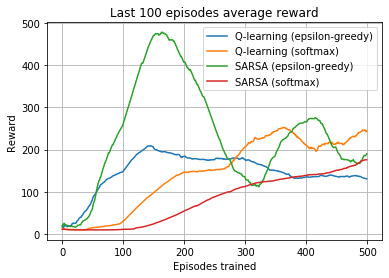

In [6]:
plt.figure()
for idx, rewards in enumerate(results["rewards_plot"]):
    plt.plot(rewards, label=results["names"][idx])
plt.grid()
plt.legend()
plt.title("Last 100 episodes average reward")
plt.xlabel("Episodes trained")
plt.ylabel("Reward")
plt.show()

In [29]:
agent.save('weights.h5')

In [8]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.load('weights.h5')

Let's now visualize how the agent is performing. Be aware that the following code to generate the video is unstable and it might break sometimes randomly. If that happens to you, just load the generated weights and try it once more, there is no need to train your model once again. 

In [10]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay==0.2.1 > /dev/null 2>&1

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
import numpy as np
import gym
import random

EasyProcessError: start error <EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb': 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [6]:
env = wrap_env(gym.make('CartPole-v1'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
done = False
state = env.reset()
state = np.reshape(state, [1, state_size])
for time in range(1000000000):
    screen = env.render()
    action = agent.exploit(state)
    state, reward, done, _ = env.step(action)
    state = np.reshape(state, [1, state_size])
    if done:
      break
env.close()
show_video()
env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.02346043,  0.02596189, -0.02559339, -0.00492287])